## Image reconstruction

Want to reproduce a [simple example](http://www.pyrunner.com/weblog/2016/05/26/compressed-sensing-python/)

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt

/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(1, 760, 600, 3)


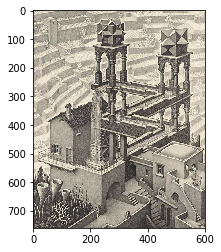

In [2]:
img = tf.image.decode_jpeg(tf.read_file('waterfall.jpg'))
img = tf.cast(img, tf.float32)/255
img = tf.expand_dims(img, 0)
# NOTE Works better with bigger images?
img = img[:, ::1, ::1, ...]
print(img.shape)
plt.imshow(img[0])

In [3]:
class Sampler():
    def __init__(self, shape, p):
        _, nx, ny, nz = shape
        N = nx * ny * nz
        k = round(N * p)
        samples = np.random.choice(N, k, replace=False)
        self.idx = tf.constant(samples, dtype=tf.int32, shape=[k])
    
    def __call__(self, x):
        return tf.gather(tf.reshape(x, [-1]), self.idx)

sampler = Sampler(img.numpy().shape, 0.25)

In [4]:
y = sampler(img)

In [5]:
def dLdx(var, target, beta=0.1):
    with tf.GradientTape() as tape:
        # the candidate var should match the measurements made
        recon = tf.losses.mean_squared_error(sampler(var), target)
        
        # project var to a sparse basis
        h = tf.fft2d(tf.cast(var, tf.complex64))
        # the l1 regularisation term
        reg = beta*tf.reduce_sum(tf.abs(h)) 
        loss = recon + reg 
        
        print('\rloss: {:.4f} recon: {:.4f} reg: {:.4f} '.format(loss, recon, reg), 
              end='', flush=True)

    return tape.gradient(loss, [var])

In [6]:
steps = 100

This is quite slow...
How does this algol scale with; size of image, many images, ...?


This is convex optimisation right!? Anything smarter we can do here?

loss: 0.0000 recon: 0.0000 reg: 0.0000 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


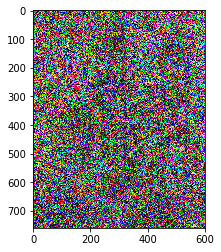

In [7]:
opt = tf.train.AdamOptimizer(0.1)

init = tf.random_normal(shape=img.shape)
var = tf.contrib.eager.Variable(init)

for i in range(steps):
    grads = dLdx(var, target=y, beta=0.00)
    gnvs = zip(grads, [var])
    opt.apply_gradients(gnvs, global_step=tf.train.get_or_create_global_step())
    
plt.figure()
plt.imshow(var[0])


loss: 0.9627 recon: 0.3753 reg: 0.5874 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


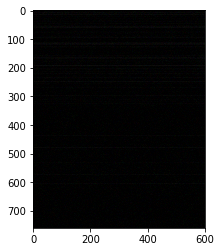

In [8]:
opt = tf.train.AdamOptimizer(0.1)

init = tf.random_normal(shape=img.shape)
var = tf.contrib.eager.Variable(init)

for i in range(steps):
    grads = dLdx(var, target=y, beta=1e-6)
    gnvs = zip(grads, [var])
    opt.apply_gradients(gnvs, global_step=tf.train.get_or_create_global_step())
    
plt.figure()
plt.imshow(var[0])

loss: 0.1685 recon: 0.0418 reg: 0.1266 

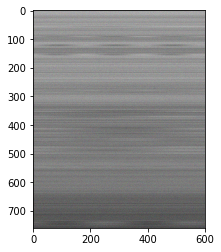

In [9]:
opt = tf.train.AdamOptimizer(0.1)

init = tf.random_normal(shape=img.shape)
var = tf.contrib.eager.Variable(init)

for i in range(steps):
    grads = dLdx(var, target=y, beta=1e-7)
    gnvs = zip(grads, [var])
    opt.apply_gradients(gnvs, global_step=tf.train.get_or_create_global_step())
    
plt.figure()
plt.imshow(var[0])

loss: 0.0307 recon: 0.0064 reg: 0.0243 

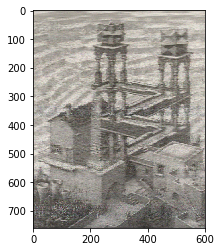

In [10]:
opt = tf.train.AdamOptimizer(0.1)

init = tf.random_normal(shape=img.shape)
var = tf.contrib.eager.Variable(init)

for i in range(steps):
    grads = dLdx(var, target=y, beta=1e-8)
    gnvs = zip(grads, [var])
    opt.apply_gradients(gnvs, global_step=tf.train.get_or_create_global_step())
    
plt.figure()
plt.imshow(var[0])

In [ ]:
opt = tf.train.AdamOptimizer(0.1)

init = tf.random_normal(shape=img.shape)
var = tf.contrib.eager.Variable(init)

for i in range(steps):
    grads = dLdx(var, target=y, beta=1e-9)
    gnvs = zip(grads, [var])
    opt.apply_gradients(gnvs, global_step=tf.train.get_or_create_global_step())
    
plt.figure()
plt.imshow(var[0])

loss: 0.0163 recon: 0.0061 reg: 0.0102 

In [ ]:
opt = tf.train.AdamOptimizer(0.1)

init = tf.random_normal(shape=img.shape)
var = tf.contrib.eager.Variable(init)

for i in range(steps):
    grads = dLdx(var, target=y, beta=0.0)
    gnvs = zip(grads, [var])
    opt.apply_gradients(gnvs, global_step=tf.train.get_or_create_global_step())
    
plt.figure()
plt.imshow(var[0])